In [2]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import sqlutilpy as sqlutil
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.table import Table

from datetime import datetime
from PIL import Image, ImageDraw, UnidentifiedImageError

from dustmaps.sfd import SFDQuery
from dustmaps.config import config
import os, io, requests
from matplotlib.colors import LogNorm


In [16]:
base_path   = os.path.expanduser("~/Work/Code/lrd_search/")

In [3]:
# output_fits = os.path.expanduser("~/data/lrd_search/all_sky_data.fits")
# df = Table.read(output_fits).to_pandas()
# print(f"Loaded FITS file into DataFrame: {output_fits}")

df = pd.read_parquet(
    "~/data/lrd_search/all_sky_data.parquet",
    engine="fastparquet"
)

In [4]:
# keep closest DECaLS per GALEX
df = df.sort_values("sep_arcsec").drop_duplicates("galex_objid")
print(f"After dropping duplicates: {len(df)}")

# Compute Gaia proper motion SNR: sqrt(pmra^2 + pmdec^2) / sqrt(pmra_error^2 + pmdec_error^2)
df["pm_total_snr"] = (
    np.sqrt(df["pmra"]**2 + df["pmdec"]**2) /
    np.sqrt(df["pmra_error"]**2 + df["pmdec_error"]**2)
)

After dropping duplicates: 19542536


In [5]:
for i, col in enumerate(df.columns):
    print(col, end='\t' if (i+1)%5 else '\n')
if len(df.columns) % 5:
    print()  # Ensure final line ends

galex_objid	decals_objid	sep_arcsec	galex_ra	galex_dec
nuv_mag	nuv_magerr	fuv_mag	fuv_magerr	nuv_class_star
fuv_class_star	e_bv	decals_ra	decals_dec	flux_g
flux_r	flux_z	flux_ivar_g	flux_ivar_r	flux_ivar_z
decals_type	shape_r	shape_e1	shape_e2	sersic
gaia2_id	g_mag	r_mag	z_mag	g_magerr
r_magerr	z_magerr	gaia2_ra	gaia2_dec	gaia2_g
gaia2_bp	gaia2_rp	gaia2_parallax	gaia2_pmra	gaia2_pmdec
gaia3_id	gaia3_ra	gaia3_dec	phot_g_mean_mag	phot_bp_mean_mag
phot_rp_mean_mag	parallax	pmra	pmdec	pmra_error
pmdec_error	parallax_over_error	ruwe	astrometric_excess_noise	astrometric_excess_noise_sig
dr2_dr3_sep_arcsec	dr2_dr3_dmag	sdss_objid	sdss_ra	sdss_dec
sdss_u	sdss_g	sdss_r	sdss_i	sdss_z
sdss_u_err	sdss_g_err	sdss_r_err	sdss_i_err	sdss_z_err
gaia3_sdss_sep_arcsec	pm_total_snr	


In [6]:
print(df['decals_type'].unique())

['PSF' 'EXP' 'REX' 'SER' 'DEV' 'DUP']


In [7]:
# --------------------------------------------------------------
# Extinction correction  (GALEX + SDSS/DECaLS u,g,r,z + Gaia)
# --------------------------------------------------------------


# -------------------------------------------------------------- #
# 0.  Query SFD E(B–V)
# -------------------------------------------------------------- #
sfd    = SFDQuery()
coords = SkyCoord(ra=df['decals_ra'].values,
                  dec=df['decals_dec'].values, unit='deg')
df['ebv'] = sfd(coords)

# -------------------------------------------------------------- #
# 1.  Aλ / E(B–V) coefficients
#    GALEX/SDSS: Schlafly & Finkbeiner 2011
#    Gaia      : Casagrande & VandenBerg 2018
# -------------------------------------------------------------- #
ext_coeff = {
    'fuv'    : 8.31,
    'nuv'    : 8.74,
    'u'      : 4.239,  
    'g'      : 3.303,
    'r'      : 2.285,
    'z'      : 1.263,
    'gaia_g' : 2.742,
    'gaia_bp': 3.172,
    'gaia_rp': 1.634,
}

# -------------------------------------------------------------- #
# 2.  Locate SDSS-u column, standardise name
# -------------------------------------------------------------- #
u_lookup = ['sdss_u', 'u_mag', 'psfMag_u']
u_obs_col = next((c for c in u_lookup if c in df.columns), None)
if u_obs_col is None:
    raise KeyError(f'Could not find u-band column (looked for {u_lookup})')
df.rename(columns={u_obs_col: 'u_mag'}, inplace=True)

# -------------------------------------------------------------- #
# 3.  Deredden GALEX + SDSS/DECaLS  (now incl. u)
# -------------------------------------------------------------- #
for band in ['fuv', 'nuv', 'u', 'g', 'r', 'z']:
    df[f'A_{band}']        = ext_coeff[band] * df['ebv']
    df[f'{band}_mag_corr'] = df[f'{band}_mag'] - df[f'A_{band}']

# -------------------------------------------------------------- #
# 4.  Locate Gaia columns, standardise names (unchanged)
# -------------------------------------------------------------- #
gaia_lookup = {
    'gaia_bp_mag': ['gaia_bp_mag','phot_bp_mean_mag','bp_mag','bp'],
    'gaia_g_mag' : ['gaia_g_mag' ,'phot_g_mean_mag' ,'g_mag' ,'g'],
    'gaia_rp_mag': ['gaia_rp_mag','phot_rp_mean_mag','rp_mag','rp'],
}
for std_name, aliases in gaia_lookup.items():
    found = next((c for c in aliases if c in df.columns), None)
    if found is None:
        raise KeyError(f'Could not find Gaia column for {std_name} '
                       f'(looked for {aliases})')
    df.rename(columns={found: std_name}, inplace=True)

# -------------------------------------------------------------- #
# 5.  Deredden Gaia passbands
# -------------------------------------------------------------- #
for gaia_pref in ['gaia_g', 'gaia_bp', 'gaia_rp']:
    df[f'A_{gaia_pref}']        = ext_coeff[gaia_pref] * df['ebv']
    df[f'{gaia_pref}_mag_corr'] = df[f'{gaia_pref}_mag'] - df[f'A_{gaia_pref}']

# -------------------------------------------------------------- #
# 6.  Set dereddened mags as the default working columns
# -------------------------------------------------------------- #
# for band in ['fuv','nuv','u','g','r','z','gaia_g','gaia_bp','gaia_rp']:
#     df[f'{band}_mag'] = df[f'{band}_mag_corr']

# -------------------------------------------------------------- #
# 7.  Sanity report
# -------------------------------------------------------------- #
print("Extinction correction applied")
print(f"E(B–V): {df['ebv'].min():.4f} – {df['ebv'].max():.4f} "
      f"(mean {df['ebv'].mean():.4f})")
for k in ['u','g','r','z','gaia_g','gaia_bp','gaia_rp']:
    print(f"A_{k}: {df[f'A_{k}'].min():.3f} – {df[f'A_{k}'].max():.3f}")
print("\nDereddened columns gaia_[bp|g|rp]_mag_corr and u_mag_corr "
      "now exist for downstream colour diagnostics.")

Extinction correction applied
E(B–V): 0.0004 – 1.3201 (mean 0.0394)
A_u: 0.002 – 5.596
A_g: 0.001 – 4.360
A_r: 0.001 – 3.016
A_z: 0.001 – 1.667
A_gaia_g: 0.001 – 3.620
A_gaia_bp: 0.001 – 4.187
A_gaia_rp: 0.001 – 2.157

Dereddened columns gaia_[bp|g|rp]_mag_corr and u_mag_corr now exist for downstream colour diagnostics.


In [8]:
objid = 6382632234073984504

# Select the row(s) in df where galex_objid matches the target objid
df_target = df[df['galex_objid'] == objid]


Number of LRD candidates selected: 69
Figure saved as: /Users/vasilybelokurov/Work/Code/lrd_search/plots/lrd_colour_colour_density.png


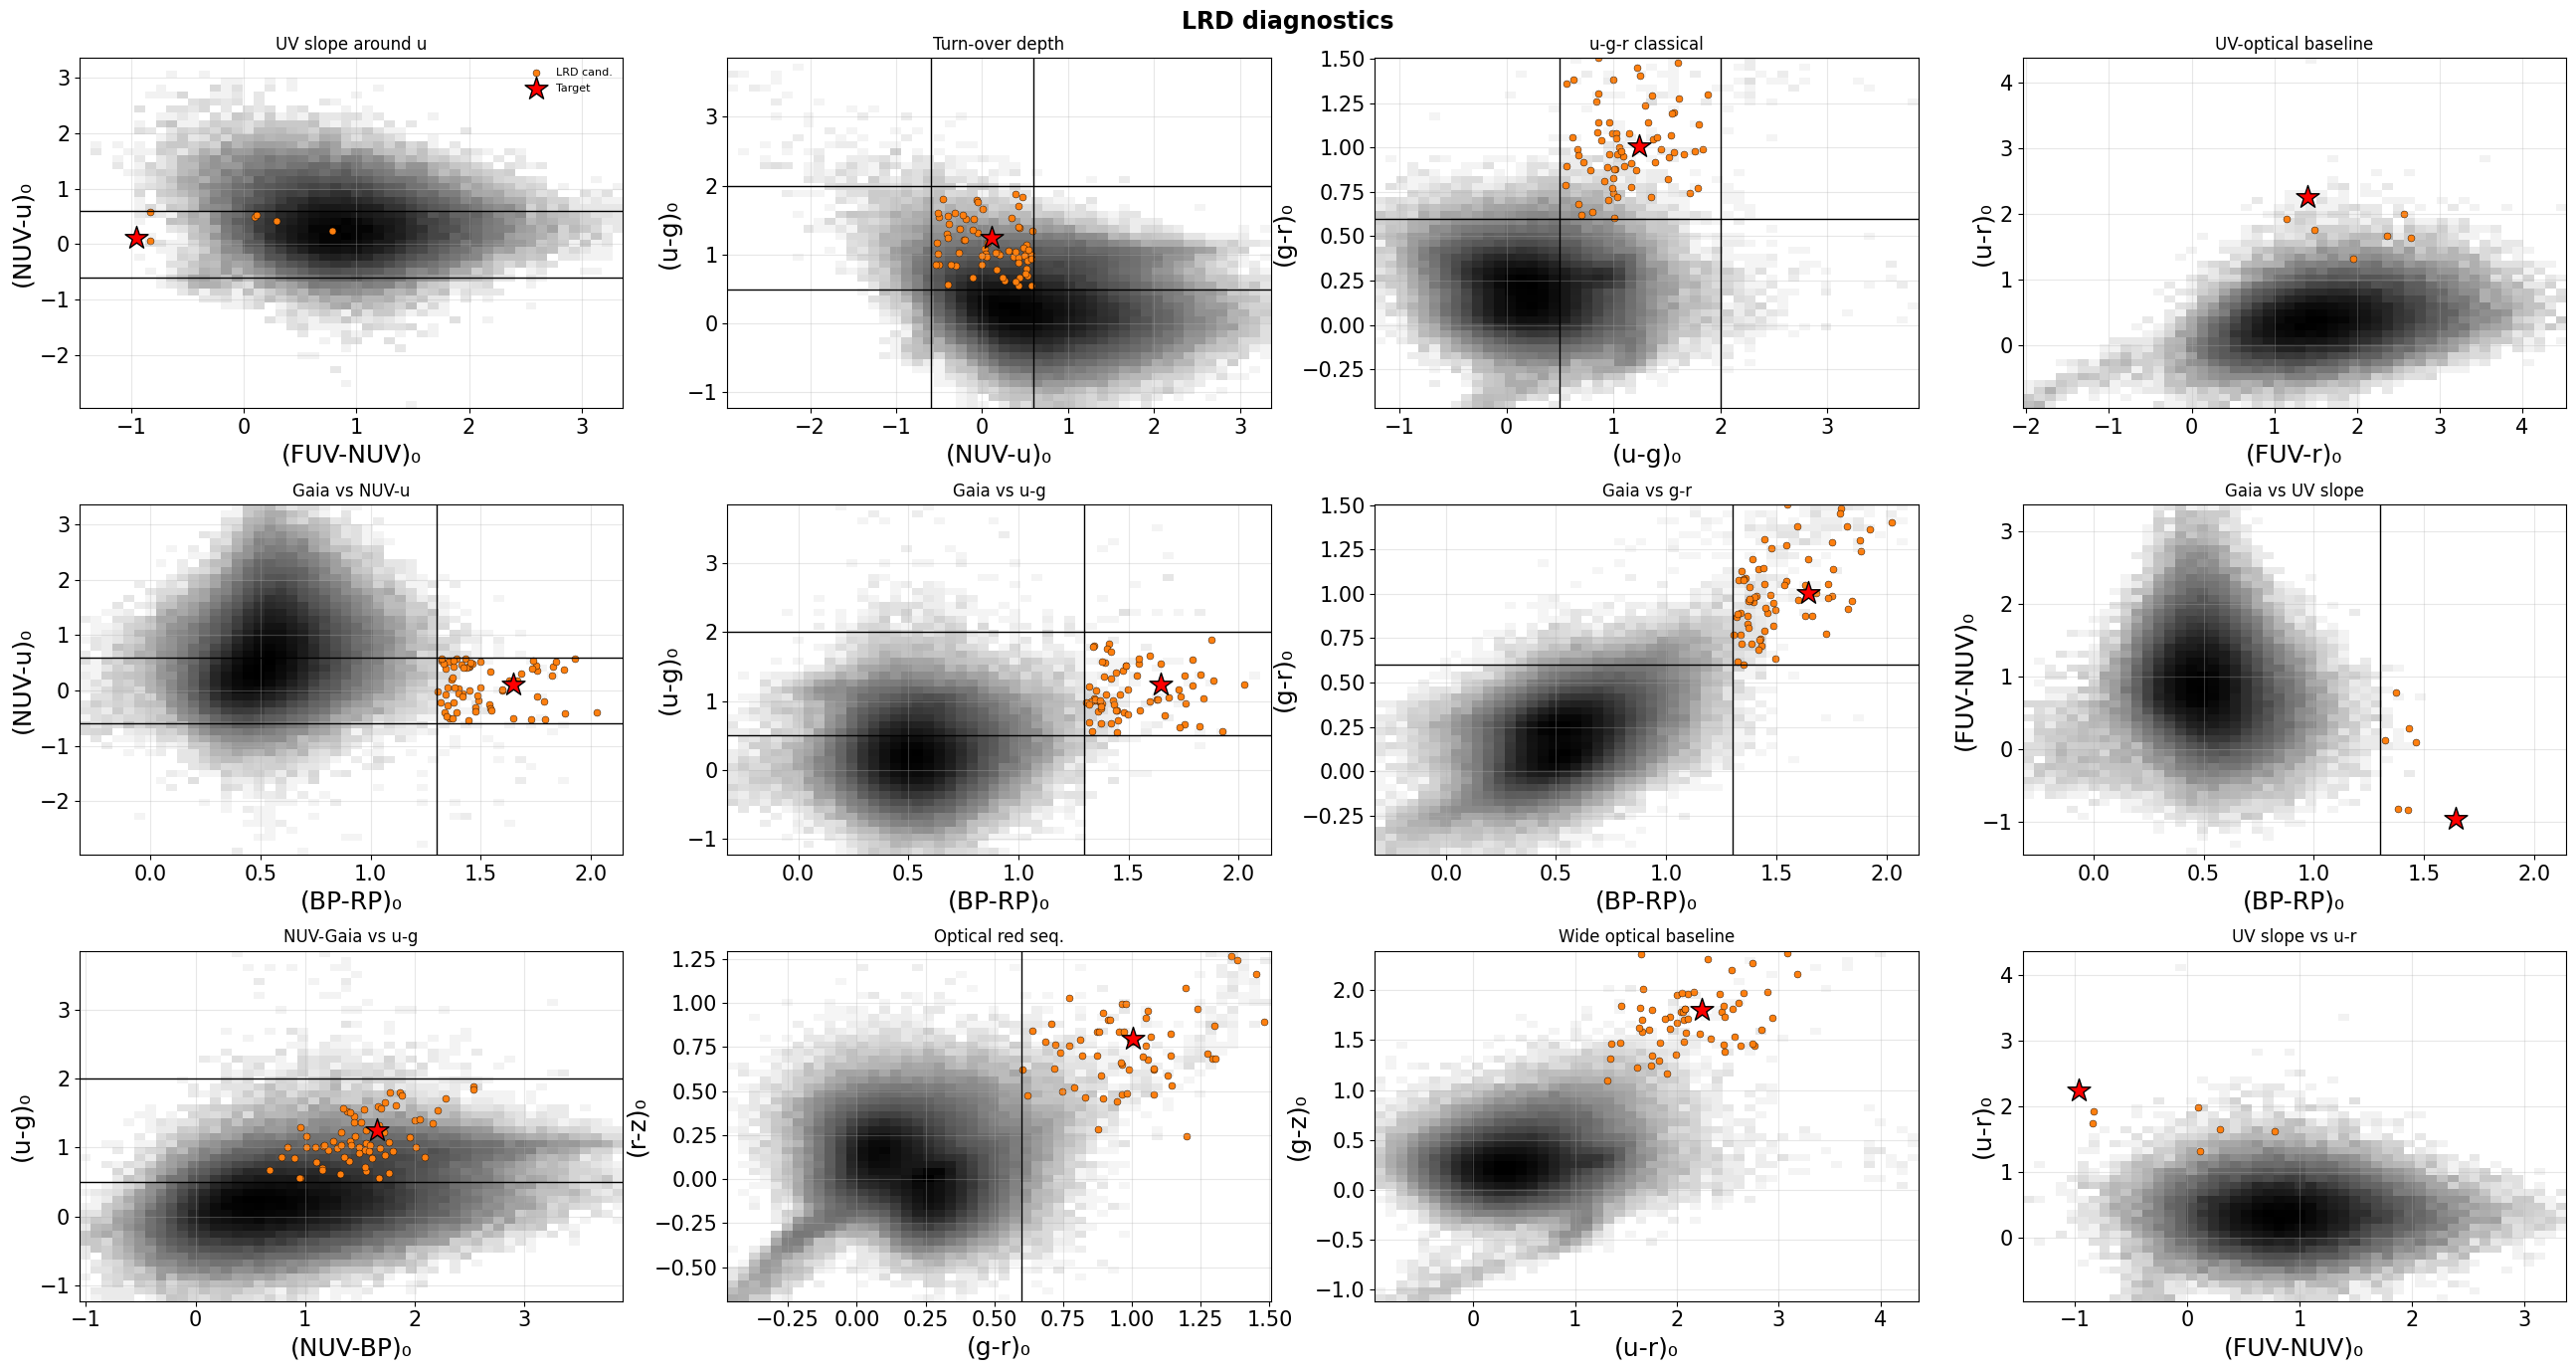

In [17]:
# ================================================================
# LRD colour–colour diagnostics   (GALEX + SDSS u,g,r,z + Gaia)
# ================================================================

plot_flag  = 'density'          #  'scatter'  or  'density'
bins_2d    = 50                 #  histogram resolution

# ----------------------------------------------------------------
# Candidate-selection criteria   {colour_key: (min, max)}
# (None ⇒ no limit on that side)
# ----------------------------------------------------------------
sel_criteria = {
    'bp_rp': (1.3, None),       # BP-RP  > 1.3
    'g_r'  : (0.6, None),      # g-r   > 0.6
    'nuv_u': (-0.6, 0.6),       # −0.6 < NUV-u < 0.6
    'u_g'  : (0.5, 2),       # 0.5 < u-g < 2
}

# ================================================================
# Helper: axis limits padded to include the target
# ================================================================
def get_axis_limits(arr, target, pad=0.5, lo=0.1, hi=99.9, vmax=10):
    good = arr[np.isfinite(arr) & (np.abs(arr) < vmax)]
    amin, amax = (-1, 1) if good.size == 0 else np.nanpercentile(good, [lo, hi])
    return min(amin, target - pad), max(amax, target + pad)

# ----------------------------------------------------------------
# 0.  Sanity check for required dereddened columns
# ----------------------------------------------------------------
needed = ['fuv_mag_corr','nuv_mag_corr','u_mag_corr','g_mag_corr',
          'r_mag_corr','z_mag_corr',
          'gaia_bp_mag_corr','gaia_g_mag_corr','gaia_rp_mag_corr']
missing = [c for c in needed if c not in df.columns]
if missing:
    raise KeyError(f"Missing columns: {missing} – run extinction cell first")

# ----------------------------------------------------------------
# 1.  Working subset: star-like extra-galactic
# ----------------------------------------------------------------
pm_snr_max, parallax_snr_max = 2, 2
idx = (
    (df['pm_total_snr'] < pm_snr_max) &
    (df['parallax_over_error'] < parallax_snr_max) &
    (df['decals_type'] == 'PSF') &
    (df['astrometric_excess_noise_sig'] < 2)
)
df_use = df.loc[idx].copy()

# ----------------------------------------------------------------
# 2.  Colour definitions   key → (bright_band, faint_band)
# ----------------------------------------------------------------
pairs = {
    'fuv_nuv': ('fuv_mag_corr',  'nuv_mag_corr'),
    'nuv_u'  : ('nuv_mag_corr',  'u_mag_corr'),
    'u_g'    : ('u_mag_corr',    'g_mag_corr'),
    'u_r'    : ('u_mag_corr',    'r_mag_corr'),
    'fuv_r'  : ('fuv_mag_corr',  'r_mag_corr'),
    'g_r'    : ('g_mag_corr',    'r_mag_corr'),
    'r_z'    : ('r_mag_corr',    'z_mag_corr'),
    'g_z'    : ('g_mag_corr',    'z_mag_corr'),
    'bp_rp'  : ('gaia_bp_mag_corr','gaia_rp_mag_corr'),
    'nuv_bp' : ('nuv_mag_corr',  'gaia_bp_mag_corr'),
}

# Colours for catalogue & (optional) target
c  = {k: df_use[p1] - df_use[p2] for k, (p1, p2) in pairs.items()}
tc = None
if len(df_target):
    trow = df.loc[df_target.index[0]]
    tc   = {k: trow[p1] - trow[p2] for k, (p1, p2) in pairs.items()}

# ----------------------------------------------------------------
# 3.  Candidate mask from sel_criteria
# ----------------------------------------------------------------
mask = np.ones(len(df_use), dtype=bool)
for col_key, (vmin, vmax) in sel_criteria.items():
    if vmin is not None:
        mask &= (c[col_key] >= vmin)
    if vmax is not None:
        mask &= (c[col_key] <= vmax)
lrd_can = mask
print(f"Number of LRD candidates selected: {lrd_can.sum()}")

# ----------------------------------------------------------------
# 4.  Plane specification
# ----------------------------------------------------------------
planes = [
    (0,0,'fuv_nuv','nuv_u' , '(FUV-NUV)₀','(NUV-u)₀', 'UV slope around u'),
    (0,1,'nuv_u' , 'u_g'   , '(NUV-u)₀' , '(u-g)₀'  , 'Turn-over depth'),
    (0,2,'u_g'   , 'g_r'   , '(u-g)₀'   , '(g-r)₀'  , 'u-g-r classical'),
    (0,3,'fuv_r' , 'u_r'   , '(FUV-r)₀' , '(u-r)₀'  , 'UV-optical baseline'),
    (1,0,'bp_rp' , 'nuv_u' , '(BP-RP)₀' , '(NUV-u)₀', 'Gaia vs NUV-u'),
    (1,1,'bp_rp' , 'u_g'   , '(BP-RP)₀' , '(u-g)₀'  , 'Gaia vs u-g'),
    (1,2,'bp_rp' , 'g_r'   , '(BP-RP)₀' , '(g-r)₀'  , 'Gaia vs g-r'),
    (1,3,'bp_rp' , 'fuv_nuv','(BP-RP)₀','(FUV-NUV)₀','Gaia vs UV slope'),
    (2,0,'nuv_bp','u_g'    , '(NUV-BP)₀','(u-g)₀'  , 'NUV-Gaia vs u-g'),
    (2,1,'g_r'   , 'r_z'   , '(g-r)₀'   , '(r-z)₀'  , 'Optical red seq.'),
    (2,2,'u_r'   , 'g_z'   , '(u-r)₀'   , '(g-z)₀'  , 'Wide optical baseline'),
    (2,3,'fuv_nuv','u_r'   , '(FUV-NUV)₀','(u-r)₀'  , 'UV slope vs u-r'),
]

# ----------------------------------------------------------------
# 5.  Plotting
# ----------------------------------------------------------------
fig, ax = plt.subplots(3, 4, figsize=(26, 14))


fig.suptitle(f'LRD diagnostics', fontsize=17, fontweight='bold')

stars, galaxies = df_use['decals_type']=='PSF', df_use['decals_type']!='PSF'

for row, col, xk, yk, xlab, ylab, title in planes:
    a = ax[row, col]
    x, y = c[xk], c[yk]

    xmin, xmax = get_axis_limits(x, tc[xk] if tc else 0)
    ymin, ymax = get_axis_limits(y, tc[yk] if tc else 0)
    a.set_xlim(xmin, xmax); a.set_ylim(ymin, ymax)
    a.set_xlabel(xlab); a.set_ylabel(ylab); a.set_title(title); a.grid(alpha=0.3)
    a.tick_params(axis='both', labelsize=15)
    a.xaxis.label.set_size(18)
    a.yaxis.label.set_size(18)

    # base visualisation
    if plot_flag == 'scatter':
        a.scatter(x[stars],    y[stars],    s=8, alpha=0.6, color='tab:blue',  label='Stars')
        a.scatter(x[galaxies], y[galaxies], s=3, alpha=0.6, color='tab:gray', label='Galaxies')
    elif plot_flag == 'density':
        mask_xy = np.isfinite(x) & np.isfinite(y)
        hist, _, _ = np.histogram2d(x[mask_xy], y[mask_xy],
                                    bins=bins_2d,
                                    range=[[xmin, xmax], [ymin, ymax]])
        # ensure vmax is at least as big as vmin
        vmax = max(hist.max(), 1)
        norm = LogNorm(vmin=1, vmax=vmax)      # now vmax >= vmin
        a.imshow(
            hist.T, origin='lower',
            extent=[xmin, xmax, ymin, ymax],
            aspect='auto', cmap='Greys',
            norm=norm
        )
    else:
        raise ValueError("plot_flag must be 'scatter' or 'density'")

    # candidate overlay
    a.scatter(x[lrd_can], y[lrd_can], s=25, marker='o',
              color='tab:orange', edgecolor='k', linewidths=0.3,
              label='LRD cand.' if (row==0 and col==0) else None)

    # target overlay
    if tc:
        a.scatter(tc[xk], tc[yk], s=300, marker='*',
                  color='red', edgecolor='k', zorder=10,
                  label='Target' if (row==0 and col==0) else None)

    # draw selection cut lines where relevant
    for col_key, (vmin, vmax) in sel_criteria.items():
        if xk == col_key:
            if vmin is not None: a.axvline(vmin, color='k', lw=1)
            if vmax is not None: a.axvline(vmax, color='k', lw=1)
        if yk == col_key:
            if vmin is not None: a.axhline(vmin, color='k', lw=1)
            if vmax is not None: a.axhline(vmax, color='k', lw=1)

    # legend once
    if row == 0 and col == 0:
        a.legend(frameon=False, fontsize=8)

# ----------------------------------------------------------------
# 6.  Save figure
# ----------------------------------------------------------------
plt.tight_layout()

output_path = f"{base_path}plots/lrd_colour_colour_{plot_flag}.png"
plt.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none')
print(f"Figure saved as: {output_path}")
plt.show()

In [11]:
# Output RA, Dec of LRD candidates in the requested format
for ra, dec in zip(df_use.loc[lrd_can, 'decals_ra'], df_use.loc[lrd_can, 'decals_dec']):
    print(f"({ra:.6f}, {dec:.6f}),")


(354.480249, 2.013534),
(10.921895, 0.881483),
(210.875275, 30.749238),
(343.842077, -9.646738),
(23.300231, 31.742213),
(215.210513, 31.092337),
(236.911819, 31.719851),
(66.399673, -4.495508),
(219.589160, 9.773104),
(173.764648, -2.898380),
(238.155925, 61.612295),
(236.837688, 49.619049),
(353.404523, -3.251746),
(227.966259, 21.777328),
(212.959222, 23.486256),
(156.376216, 14.035388),
(314.773826, -5.213010),
(351.038837, -3.092174),
(123.549326, 55.670092),
(5.152149, 28.881402),
(261.289022, 32.442865),
(162.827221, 8.306628),
(337.041501, 13.347446),
(134.822822, 9.908712),
(44.274044, -2.032631),
(136.195564, 58.350236),
(1.605899, -4.167709),
(30.545919, -4.451049),
(338.987786, 15.550345),
(231.408754, 41.533478),
(158.599131, -2.476859),
(170.352384, 57.091484),
(195.918671, 13.447945),
(32.563114, -3.735333),
(208.706344, 2.124146),
(164.482324, 58.432848),
(145.788729, 33.631390),
(149.813751, 3.676001),
(194.052494, 27.974777),
(161.212050, 60.872274),
(229.980830, 19.4

In [12]:

radec_tbl = Table()
radec_tbl['ra']  = df_use.loc[lrd_can, 'decals_ra'].values
radec_tbl['dec'] = df_use.loc[lrd_can, 'decals_dec'].values
radec_tbl.write(os.path.expanduser("~/data/lrd_search/lrd_can_radec.fits"), overwrite=True)
print("Saved RA, DEC of LRD candidates to ~/data/lrd_search/lrd_can_radec.fits")

Saved RA, DEC of LRD candidates to ~/data/lrd_search/lrd_can_radec.fits


In [13]:
# Save the LRD candidates DataFrame to a Parquet file
df_lrd_can = df_use[lrd_can].copy()
df_lrd_can.to_parquet(
    os.path.expanduser("~/data/lrd_search/lrd_candidates.parquet"),
    engine="fastparquet"
)
print("Saved LRD candidates to ~/data/lrd_search/lrd_candidates.parquet")

Saved LRD candidates to ~/data/lrd_search/lrd_candidates.parquet


In [14]:
sel = (df_lrd_can['fuv_mag_corr'] - df_lrd_can['nuv_mag_corr'] < 0) & \
    ((df_lrd_can['fuv_mag_corr'] - df_lrd_can['nuv_mag_corr']).abs() < 5)
for ra, dec in zip(df_lrd_can.loc[sel, 'decals_ra'], df_lrd_can.loc[sel, 'decals_dec']):
    print(f"{ra:.6f}, {dec:.6f}")

227.966259, 21.777328
156.376216, 14.035388
8.333807, 30.001778


/var/folders/jb/7f0bq_sx0435s1wvlt2yfkcr0000gn/T/ipykernel_74544/3561303908.py:26: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  print(f"{datetime.utcnow():%Y-%m-%d %H:%M:%S}  "


2025-08-11 15:59:37  Fetching 69 DECaLS cut-outs  (15.0″ FoV, 57×57 px)…
[1/69] saved → lrdcand_0000_RA354.4802_Dec2.0135.jpg
[2/69] saved → lrdcand_0001_RA10.9219_Dec0.8815.jpg
[3/69] saved → lrdcand_0002_RA210.8753_Dec30.7492.jpg
[4/69] saved → lrdcand_0003_RA343.8421_Dec-9.6467.jpg
[5/69] saved → lrdcand_0004_RA23.3002_Dec31.7422.jpg
[6/69] saved → lrdcand_0005_RA215.2105_Dec31.0923.jpg
[7/69] saved → lrdcand_0006_RA236.9118_Dec31.7199.jpg
[8/69] saved → lrdcand_0007_RA66.3997_Dec-4.4955.jpg
[9/69] saved → lrdcand_0008_RA219.5892_Dec9.7731.jpg
[10/69] saved → lrdcand_0009_RA173.7646_Dec-2.8984.jpg
[11/69] saved → lrdcand_0010_RA238.1559_Dec61.6123.jpg
[12/69] saved → lrdcand_0011_RA236.8377_Dec49.6190.jpg
[13/69] saved → lrdcand_0012_RA353.4045_Dec-3.2517.jpg
[14/69] saved → lrdcand_0013_RA227.9663_Dec21.7773.jpg
[15/69] saved → lrdcand_0014_RA212.9592_Dec23.4863.jpg
[16/69] saved → lrdcand_0015_RA156.3762_Dec14.0354.jpg
[17/69] saved → lrdcand_0016_RA314.7738_Dec-5.2130.jpg
[18/69]

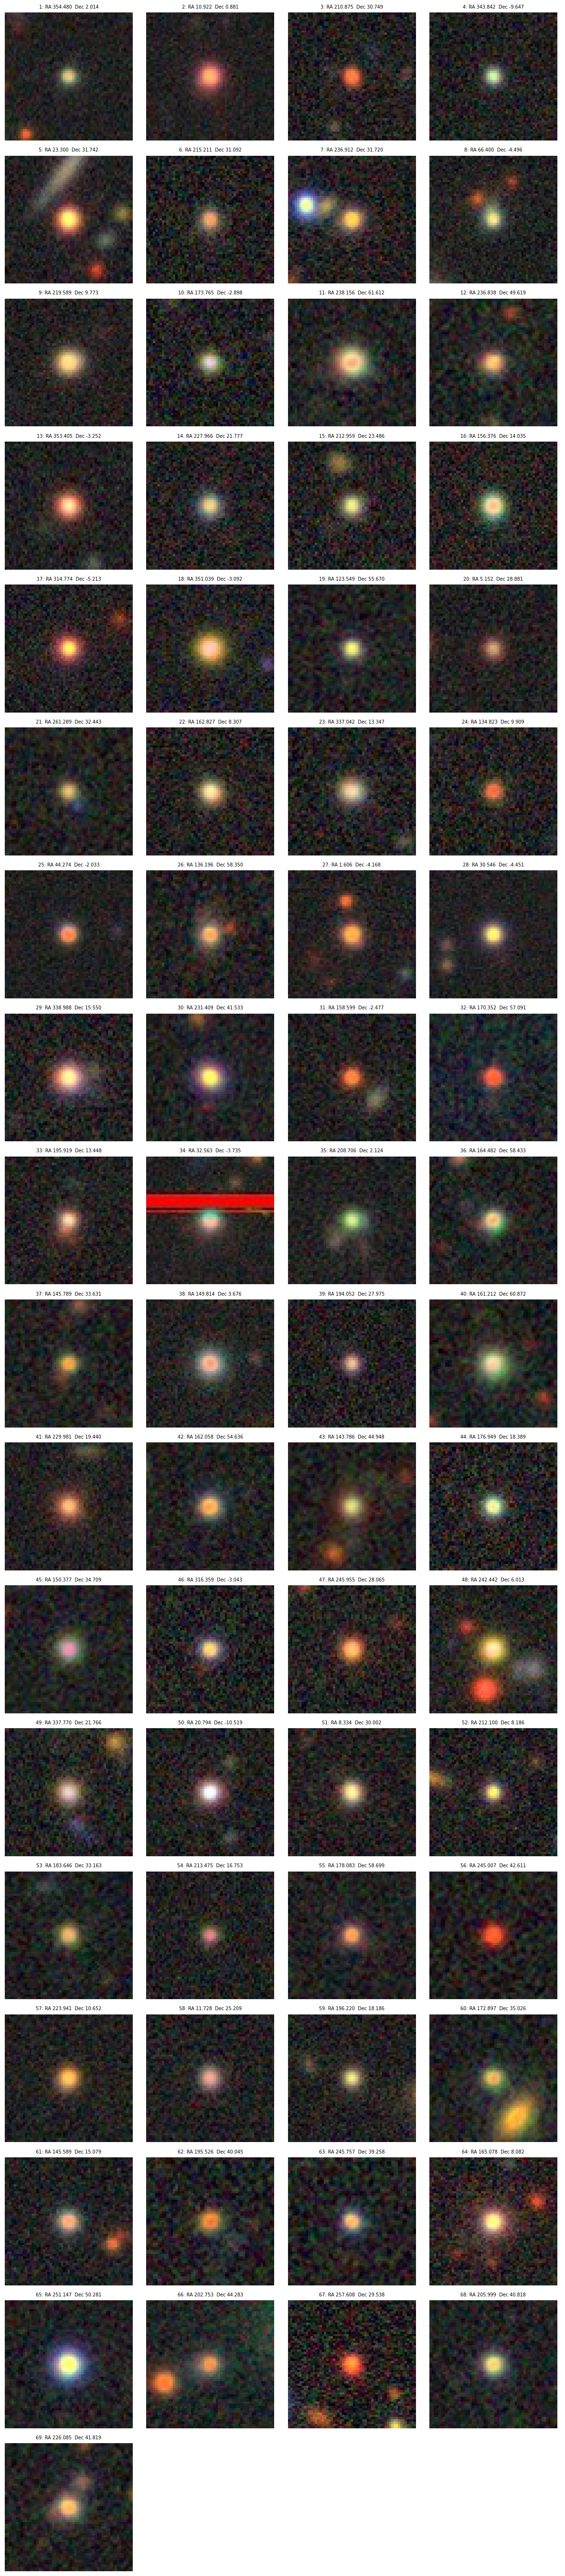

In [18]:
# ================================================================
# DECaLS cut-outs for LRD candidates  –  download + gallery
# ================================================================

# ----------------------------------------------------------------
# 0.  Setup
# ----------------------------------------------------------------
fov_arcsec = 15.0           # full side length of the stamp   ← EDIT HERE
pixscale   = 0.262          # native DECaLS (arcsec / pix)
size_pix   = max(16, int(round(fov_arcsec / pixscale)))   # ensure ≥16 px
layer      = 'ls-dr9'
bands      = 'grz'
timeout    = 10             # HTTP timeout (s)

download_folder = os.path.join(base_path, "decals_cutouts_jpg/")
os.makedirs(download_folder, exist_ok=True)

# ----------------------------------------------------------------
# 1.  Candidate table  (df_use & lrd_can from previous cell)
# ----------------------------------------------------------------
df_cand = df_use[lrd_can].reset_index(drop=True)
ncand   = len(df_cand)
if ncand == 0:
    raise RuntimeError("No candidates to fetch!")

print(f"{datetime.utcnow():%Y-%m-%d %H:%M:%S}  "
      f"Fetching {ncand} DECaLS cut-outs  ({fov_arcsec}″ FoV, {size_pix}×{size_pix} px)…")

# ----------------------------------------------------------------
# 2.  Download loop  (JPEG)
# ----------------------------------------------------------------
base_url = "https://www.legacysurvey.org/viewer/cutout.jpg"
images   = []          # keep PIL images in memory for gallery

for idx, row in df_cand.iterrows():
    ra_cur, dec_cur = row['decals_ra'], row['decals_dec']
    params = {
        'ra'      : f"{ra_cur:.6f}",
        'dec'     : f"{dec_cur:.6f}",
        'layer'   : layer,
        'pixscale': pixscale,
        'size'    : size_pix,
        'bands'   : bands,
    }
    url = requests.Request('GET', base_url, params=params).prepare().url

    try:
        r = requests.get(url, timeout=timeout)
        r.raise_for_status()
        if 'image' not in r.headers.get('content-type',''):
            raise UnidentifiedImageError("Non-image response")
        img = Image.open(io.BytesIO(r.content)).convert('RGB')
    except Exception as e:
        # create a placeholder tile
        img = Image.new('RGB', (size_pix, size_pix), color='black')
        draw = ImageDraw.Draw(img)
        draw.text((4, size_pix//2 - 6), "ERR", fill="white")
        print(f"[{idx+1}/{ncand}] FAILED  RA={ra_cur:.3f}  Dec={dec_cur:.3f} : {e}")

    # save to disk
    fname = f"lrdcand_{idx:04d}_RA{ra_cur:.4f}_Dec{dec_cur:.4f}.jpg"
    fpath = os.path.join(download_folder, fname)
    img.save(fpath, quality=92)
    images.append(img)

    print(f"[{idx+1}/{ncand}] saved → {fname}")

# ----------------------------------------------------------------
# 3.  Gallery (4 per row) + Save individual cutouts as PNG
# ----------------------------------------------------------------
# Create directory for individual PNG cutouts

ncols, nrows = 4, math.ceil(len(images)/4)
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*3, nrows*3))

for i, img in enumerate(images):
    ax = axes.flat[i] if nrows > 1 else axes[i]
    ax.imshow(img)
    ra, dec = df_cand.loc[i, ['decals_ra','decals_dec']]
    ax.set_title(f"{i+1}: RA {ra:.3f}  Dec {dec:.3f}", fontsize=7)
    ax.axis('off')
    
    # Save individual cutout as PNG using same filename logic as vizier_sed.ipynb
    # Create individual figure for this cutout
    fig_single, ax_single = plt.subplots(1, 1, figsize=(6, 6))
    ax_single.imshow(img)
    ax_single.set_title(f"DECaLS Cutout: RA={ra:.6f}°, Dec={dec:.6f}°\n"
                       f"FoV={fov_arcsec}″, {size_pix}×{size_pix} px, {bands}-band", 
                       fontsize=10)
    ax_single.axis('off')
    
    # Generate filename with RA and Dec (same logic as vizier_sed.ipynb)
    filename = f"decals_ra{ra:08.4f}_dec{dec:+08.4f}.png"
    filepath = os.path.join(individual_cutout_folder, filename)
    
    # Save the individual cutout
    plt.close(fig_single)  # Close to free memory
    
    print(f"   💾 Saved: {filename}")

# hide any empty panels
for j in range(len(images), nrows*ncols):
    axes.flat[j].axis('off')

plt.tight_layout()
plt.savefig(os.path.join(base_path, "plots/lrd_candidates_gallery.png"), dpi=150, bbox_inches='tight')
print(f"\n   Gallery saved to: {base_path}plots/")
print(f"   Individual cutouts saved to: {download_folder}")
plt.show()

In [56]:
# ================================================================
# Which LRD candidates are in SDSS-DR16Q?
# ================================================================


# ----------------------------------------------------------------
# 0.  Assemble the local table that will be streamed to the DB
# ----------------------------------------------------------------
df_cand  = df_use[lrd_can].reset_index(drop=True)
cand_idx = np.arange(len(df_cand))
ra_arr   = df_cand['decals_ra'].values
dec_arr  = df_cand['decals_dec'].values

# ----------------------------------------------------------------
# 1.  Build SQL for the radial cross-match (1″)
# ----------------------------------------------------------------
remote_table = 'sdssdr16qso.main'
radius_deg   = 3. / 3600.        # 1 arcsec

sql = f"""
SELECT  m.cand_idx,
        q.objid,
        q.z
FROM    mytmptable AS m,
        {remote_table} AS q
WHERE   q3c_radial_query(q.ra, q.dec, m.ra, m.dec, {radius_deg})
"""

# ----------------------------------------------------------------
# 2.  Execute with sqlutilpy.local_join
# ----------------------------------------------------------------
res = sqlutil.local_join(
        sql,
        'mytmptable',
        (cand_idx,  ra_arr,  dec_arr),
        ('cand_idx','ra',    'dec'),
        db='wsdb',
        asDict=True)            # dict → handy DataFrame later

df_match = pd.DataFrame(res)
print(f"Matches within 1″: {len(df_match)}\n")

# ----------------------------------------------------------------
# 3.  Print RA, Dec, ObjID, z for each match
# ----------------------------------------------------------------
if df_match.empty:
    print("No LRD candidates found in SDSS-DR16Q.")
else:
    for _, r in df_match.iterrows():
        i        = int(r['cand_idx'])
        ra_cand  = ra_arr[i]
        dec_cand = dec_arr[i]
        objid    = int(r['objid'])
        zqso     = float(r['z'])
        print(f"RA={ra_cand:10.6f}  Dec={dec_cand:10.6f}   "
              f"ObjID={objid}   z={zqso:.4f}")

Matches within 1″: 23

RA=251.147127  Dec= 50.281261   ObjID=1237668502758162733   z=1.2865
RA=238.155925  Dec= 61.612295   ObjID=1237671769075351725   z=0.6780
RA=178.083002  Dec= 58.699055   ObjID=1237655106765783243   z=0.7640
RA=164.482324  Dec= 58.432848   ObjID=1237655108373315776   z=1.0690
RA=170.352384  Dec= 57.091484   ObjID=1237661353777562113   z=2.3840
RA=143.786150  Dec= 44.948000   ObjID=1237657630053892893   z=0.7380
RA=343.842077  Dec= -9.646738   ObjID=1237656538052886978   z=1.3215
RA=  1.605899  Dec= -4.167709   ObjID=1237672842818879715   z=1.1927
RA=337.770195  Dec= 21.766071   ObjID=1237666244147282021   z=0.6424
RA= 10.921895  Dec=  0.881483   ObjID=1237663716556013774   z=0.8339
RA= 11.727513  Dec= 25.209096   ObjID=1237680070708953473   z=0.9108
RA=  5.152149  Dec= 28.881402   ObjID=1237680331105239926   z=1.9939
RA=149.813751  Dec=  3.676001   ObjID=1237654601026437433   z=0.6820
RA=150.376999  Dec= 34.708752   ObjID=1237662225129078912   z=0.6256
RA=196.2198